# Jax・Brax・HaikuでGPU引きこもり学習
> 強化学習若手の会 Advent Calendar 2021 18日目

- toc: true 
- badges: true
- comments: true
- categories: [ja]

# 0. 時勢のあいさつとか

> Note: このブログは[強化学習若手の会 Advent Calendar 2021](https://adventar.org/calendars/6362) 18日目の記事として書かれました

こんにちは。
コロナ禍も終わりが見えつつある（と思ったら変異株が...）2021年もあとわずか。寒さも厳しくなってきましたが、皆さん如何お過ごしでしょうか。
僕は沖縄にいるのであまり寒くはないし虫歯の治療中で奥歯に穴が空いている以外はおおむね元気です。

[若手の会](https://young-reinforcement.github.io/)のアドベントカレンダーということで、国内でのコミュニティの活動について、最初に総括してみたいと思います。

- 若手の会では模倣学習の勉強会をしましたが、結局2回しか続きませんでした。
- 苦手の会のもくもく会はフリスビーやマラソンの練習とバッティングしてやらなくなってしまいましたが、最近日程を変えて、火曜日の夜に始めました。暇な方一緒にもくもくしましょう。
- [強化学習の講義資料の翻訳](https://tadashik.github.io/rltheory-jp/)をしています。難しいですが、けっこう勉強になります。有限サンプルでのバウンドを、初めて勉強しました。興味がある方は、ぜひ一緒にやりましょう。
- 昨年の[ブログ](https://kngwyu.github.io/rlog/ja/2020/12/22/understanding-what-makes-rl-difficult.html)を書いてからはや一年、せっかく専用のブログを作ったので今年もいい感じに~~matplotlib芸~~強化学習の記事を書いていきたいと思っていましたが、結局何も書きませんでした。

最近は人工進化や人工生命の研究も始めたので、もはや「強化学習の人」と名乗っていいのかよくわかりませんが、今後も国内のコミュニティに何か貢献できればと思います。

今年は強化学習に対する楽観論も悲観論も多く目にした一年でした。
David SilverやSuttonは[Reward is Enough](https://www.sciencedirect.com/science/article/pii/S0004370221000862)という強気な論文を出し、知的なシステムはおよそ全て報酬最大化で作れると主張しました。
さすがに強気すぎると思いますが、その後[Reward is enough for convex MDPs](https://arxiv.org/abs/2106.00661)や[On the Expressivity of Markov Reward](https://openreview.net/forum?id=9DlCh34E1bN)といったテクニカルな論文が出てきたのは面白いです。
また、オフライン強化学習・教師なし強化学習の論文が増えてきたと思います。
ざっくり、**オフライン強化学習 = 強化学習 - 探索**、**教師なし強化学習 = 強化学習 - 報酬**と思ってもらって問題ないでしょう。
何を隠そう僕の修士論文も単なる「階層型強化学習」だったのですが、~~リジェクト~~諸般の事情により教師なしに魔改造して再投稿しました。
Sergey Levineにいたっては[Understanding the World Through Action](https://arxiv.org/abs/2110.12543)というタイトルが強い論文の中で、「大量にデータを集めてオフライン教師なし強化学習をすれば世界を理解できる（≒世界を理解しているのと同等のシステムが作れる？）」と言っています。面白い方向性だと思います。
一方で、みんな大好き[ルービックキューブ論文](https://openai.com/blog/solving-rubiks-cube/)を出したOpen AIのロボティクスチームは、「とりあえず今データがある領域に注力する」とのことで[解散](https://venturebeat.com/2021/07/16/openai-disbands-its-robotics-research-team/)してしまいました。
このブログを書いている最中に[WebGPT](https://openai.com/blog/improving-factual-accuracy/)の論文を目にしましたが、今後は言語モデル＋強化学習で色々やっていくのでしょうか。品川さんは喜びそうですが、僕なんかはこういう到底自分でできないものは「テレビの中の研究」という感じがして一歩引いてしまいます（最近は、テレビとかたとえに使うと古いのかな...）。
Open AIのロボティクスは、Sim2Realにこだわりすぎたのでは？という意見を某所でお聞きしました。実際そうなのかは知りませんが、大規模にシミュレーションしてSim2Realを頑張るのか、実機のデータで頑張るのかというのは、面白い視点ですよね。

Open AIが今までほど強化学習に注力しなくなったことで、[Open AI gym](https://gym.openai.com/)をはじめ強化学習研究で使われてきたソフトウェア群にも、色々と情勢の変化がありそうです。
1. [OpenAI Gymのメンテナが変わりました](https://github.com/openai/gym/issues/2259)。これからはOpen AIではなくメリーランド大学の学生さんがメンテナになるようです。mujoco-pyなど関連するライブラリについては相変わらず放置されています。
2. [DeepmindがMuJoCoを買い取って無料にしました](https://deepmind.com/blog/announcements/mujoco)。今後ソースコードも公開されるようです。
3. Googleから新しく[brax](https://github.com/google/brax)というシミュレータが公開されました。

そんなわけで、僕はこれまでmujoco-py + gymで作成した[カスタム環境](https://github.com/kngwyu/mujoco-maze/)でたくさん実験をやってきましたが、MuJoCoを使うにしてもdm_controlを使うとか、はたまたbraxにしてしまうとか、別の選択肢を検討したくなってきました。
このブログでは、とりあえずbraxを試してみようと思います。

# 1. はじめに: シミュレーション・謎ロボット・GPU

本題に入りますが、ざっくり、強化学習とは、**報酬**から**行動**を学習する枠組みだと言うことができます。
では**何の**行動を学習させたいのでしょうか。
ゲームのAIだったり、チャットボットだったり、色々な選択肢があると思いますが、どういうわけか**シミュレータ上で動く謎ロボット**というのがポピュラーな選択肢です。

このブログをごらんの方の中には、こういったナナフシのような謎ロボットの画像を目にしたことがある方も多いのではないでしょうか。

<img src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/HalfCheetah-v2/poster.jpg" alt="halfcheeta" width="300"/>

これはOpen AI gymのHalfCheetahというロボットです。足が2本なのでハーフなのだと思いますが、なんとも残酷なネーミングです。愛玩されるため病気のまま品種改良されてきた犬猫のような哀愁が漂います。

MuJoCoシミュレーターに「こことここがジョイントで、可動域はこうです。床は白黒でお願いします」みたいなXMLファイルを渡すと、こういうロボットを作ってくれます。
もしくは、[dm_control](https://github.com/deepmind/dm_control)などのPythonライブラリにXMLを作らせることもできます。
このような謎ロボットが実験で広く使われている要因として、
- みんなが使っているから
- Atariなどのゲームより高速
- ジョイントの速さ・位置などの完全な内部状態が手に入る
  - マルコフ性について心配しなくてもいい
- 色々カスタマイズできて便利だから
- 普通のロボットを訓練するためのテストにちょうどいいから
などの理由があると思いますが、なんだかんだみんなが使っているからというのが大きい気がします。

ところで、このMuJoCoシミュレータというのは非常に高速に動作するのですが、CPU上でしか動作しません。
今日使われている深層学習のコードは、その計算量のほとんどを占める行列演算がベクトル並列化ととても相性がいいため、ネットワークやバッチサイズが大きくなればなるほどGPU上で高速に動作します。
となると、GPUで学習を回している場合、どうしてもCPUからGPUにデータを転送するボトルネックが発生し、高速化の妨げになります。
そこで、GPU上でシミュレーションを行えるようにしたのが、今回紹介するbraxというシミュレータです。

# 2. Jaxでnumpy演算を高速化してみる

では、braxはCUDAか何かで書かれているのかな？と思ったかもしれませんが、なんと全てPythonで書かれているのです。
その鍵となるのが[jax](https://jax.readthedocs.io)というライブラリです。
おもむろに、インストールしてみましょう。

In [1]:
! pip install jax

'JAX is Autograd and XLA'とありますが、Jaxは
- Numpy演算をXLAに変換するコンパイラ(Tensorflow)
  - `jax.jit`
  - [XLA](https://www.tensorflow.org/xla)はTensorflowのバックエンドとして開発された中間言語で、GPU/TPU用にすごく速いコードを生成できる
- Numpy演算を追跡して勾配を計算する機能
  - `jax.grad`/`jax.vjp` など
の2つのコア機能を核とするライブラリです。
このチャプターでは、ひとまず前者の「XLAに変換するコンパイラ」としての機能に焦点を当ててみます。

コンパイラは[JIT](https://ja.wikipedia.org/wiki/%E5%AE%9F%E8%A1%8C%E6%99%82%E3%82%B3%E3%83%B3%E3%83%91%E3%82%A4%E3%83%A9)方式で実装されており、
1. [`jax.jit`](https://jax.readthedocs.io/en/latest/jax.html#jax.jit)に関数`f`を渡す (`f_compiled = jax.jit(f)`）
2. コンパイルされる関数`f_compiled`を最初に呼び出したとき、jaxはPythonの関数をXLAにコンパイルする
3. 2回目以降関数呼び出しが高速になる
という処理の流れになります。

では、さっそく何かシミュレーションしてみましょう。
適当に天井からボールを落としてみましょう。

In [1]:
# アニメーション用のライブラリ
! pip install celluloid seaborn pandas

In [4]:
import typing as t

import numpy as np
import pandas as pd
import seaborn as sns
from celluloid import Camera
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation

sns.set_theme(style="darkgrid")

Array = np.ndarray
GRAVITY = -9.8

def move_balls(
    ball_positions: Array,
    ball_velocities: Array,
    delta_t: float = 0.1,
) -> Array:
    accel_x = np.zeros(ball_positions.shape[0])
    accel_y = np.ones(ball_positions.shape[0]) * GRAVITY * delta_t # y方向にGΔt加速
    new_velocities = np.stack((accel_x, accel_y), axis=1) + ball_velocities
    new_positions = ball_positions + delta_t * new_velocities
    return new_positions, new_velocities

def simulate_balls(
    n_balls: int,
    n_steps: int = 100,
    forward: t.Callable[[Array], Array] = move_balls,
) -> t.List[Array]:
    p = np.random.uniform(size=(n_balls, 2), low=-50, high=50.0)
    v = np.random.randn(n_balls, 2)
    results = [p]
    for _ in range(n_steps):
        p, v = forward(p, v)
        results.append(p)
    return results

適当にボールを20個落としてみます。

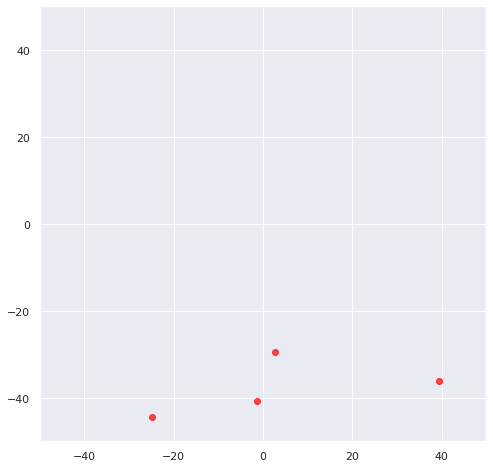

In [102]:
# collapse-hide

def ball_animation(balls: t.Iterable[Array]) -> ArtistAnimation:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    camera = Camera(fig)
    for ball_batch in balls:
        ax.scatter(ball_batch[:, 0], ball_batch[:, 1], color="red", alpha=0.7)
        camera.snap()
    return camera.animate()


HTML(ball_animation(simulate_balls(20, 40)).to_jshtml())

では、このシミュレーションをするのに、どれくらい時間がかかるでしょうか。ボールの数を変えてベンチマークしてみましょう。

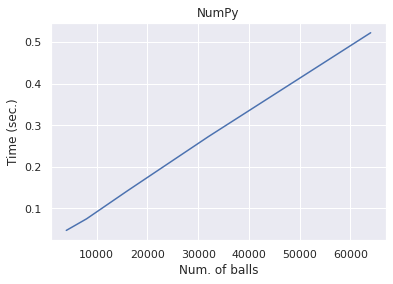

In [6]:
def bench(
    f: t.Callable[..., t.Any],
    inputs: t.Iterable[t.Any],
    number: int = 10,
) -> t.List[float]:
    import timeit

    return [timeit.Timer(lambda: f(x)).timeit(number=number) for x in inputs]


def bench_and_plot(f: t.Callable[..., t.Any], title: str) -> pd.DataFrame:
    inputs = [4000, 8000, 16000, 32000, 64000]
    result = pd.DataFrame({"x": inputs, "y": bench(f, inputs)})
    result["Method"] = [title] * len(inputs)
    ax = sns.lineplot(data=result, x="x", y="y")
    ax.set_title(title)
    ax.set_xlabel("Num. of balls")
    ax.set_ylabel("Time (sec.)")
    return result


numpy_result = bench_and_plot(simulate_balls, "NumPy")

おおむね線形に実行時間が増えていることがわかります。このコードを、jaxを使って高速化してみましょう。
基本的には`numpy`を`jax.numpy`に置き換えればいいです。

In [7]:
import jax
import jax.numpy as jnp

JaxArray = jnp.DeviceArray

def move_balls_jax(
    ball_positions: JaxArray,
    ball_velocities: JaxArray,
    delta_t: float = 0.1,
) -> JaxArray:
    accel_x = jnp.zeros(ball_positions.shape[0])
    accel_y = jnp.ones(ball_positions.shape[0]) * GRAVITY * delta_t
    new_velocities = jnp.stack((accel_x, accel_y), axis=1) + ball_velocities
    new_positions = ball_positions + delta_t * new_velocities
    return new_positions, new_velocities

では同じようにベンチマークをとってみましょう。

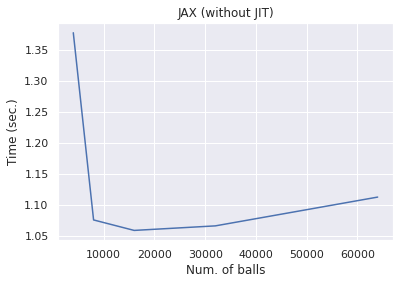

In [8]:
jax_nojit_result = bench_and_plot(
    lambda n: simulate_balls(n, forward=move_balls_jax),
    "JAX (without JIT)",
)

謎の挙動を見せているし、すごく遅いですね。今度はJITコンパイルしてみましょう。
`jax.jit(f, backend="CPU")`で関数をCPU上で動くXLAコードにコンパイルできます。

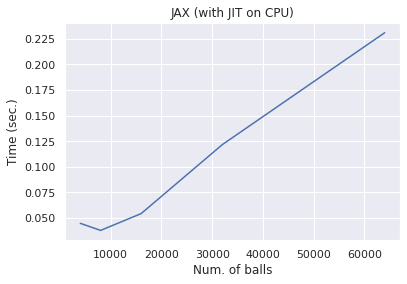

In [9]:
jax_cpu_result = bench_and_plot(
    lambda n: simulate_balls(n, forward=jax.jit(move_balls_jax, backend="cpu")),
    "JAX (with JIT on CPU)",
)

すごく速くなりました。今度はGPUでやってみます。

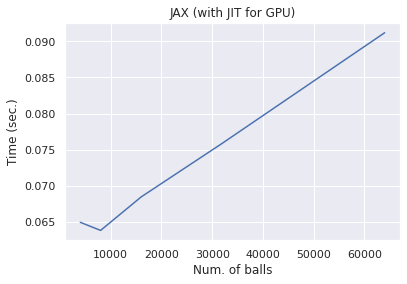

In [10]:
jax_gpu_result = bench_and_plot(
    lambda n: simulate_balls(n, forward=jax.jit(move_balls_jax, backend="gpu")),
    "JAX (with JIT for GPU)",
)

圧倒的に速いですね。ボールの数が32000から64000のところで、傾きが緩やかになっているほどです。
まとめるとこんな感じになります。

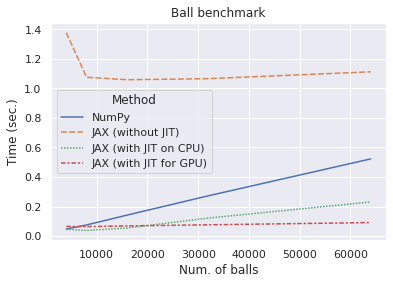

In [11]:
# collapse-hide
ax = sns.lineplot(
    data=pd.concat(
        [numpy_result, jax_nojit_result, jax_cpu_result, jax_gpu_result],
        ignore_index=True,
    ),
    x="x",
    y="y",
    style="Method",
    hue="Method",
)
ax.set_title("Ball benchmark")
ax.set_xlabel("Num. of balls")
ax.set_ylabel("Time (sec.)")
None

このボールの数だとGPUは線形に計算時間が増えているように見えませんね。
まあ何はともあれ、GPU用にJITコンパイルしてあげると速そうだなあ、という感じがします。

# 3. Jaxで勾配を計算してみる

Jaxは単に速いNumPyとしての機能に加え、自動微分によって、関数$f(x, y, z, ...)$の各$x, y, z,...$による偏微分$\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}, ...$を計算する機能を持っています。ここでは`jax.grad`による勾配の計算だけを紹介します。

なんか、適当に関数を最適化しましょう。まずは、適当に関数を決めてみます。
$z = x^2 + y^2 + y$ にしました。

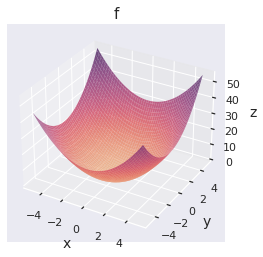

In [43]:
def f(x, y):
    return x ** 2 + y ** 2 + y


def plot_f(traj: t.Optional[Array] = None) -> None:
    x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(
        x,
        y,
        f(x, y),
        cmap=sns.color_palette("flare", as_cmap=True),
        alpha=0.8,
        linewidth=0,
    )
    if traj is not None:
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color="blue")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_zlabel("z", fontsize=14, horizontalalignment="right")
    ax.set_title("f", fontsize=15)


plot_f()

$(x, y) = (5, 5)$でのこの関数の勾配を計算してみます。勾配を計算してほしい引数を`jax.jit(argnums=...)`で指定します。

In [44]:
jax.grad(f, argnums=(0, 1))(jnp.array(5.0), jnp.array(5.0))

(DeviceArray(10., dtype=float32, weak_type=True),
 DeviceArray(11., dtype=float32, weak_type=True))

$\frac{\partial z}{\partial x}, \frac{\partial z}{\partial y}$を計算してくれました。
せっかくなので、最急降下法してみましょう。

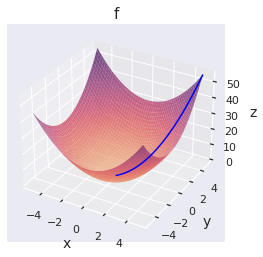

In [46]:
def steepest_descent(alpha: float = 0.01) -> JaxArray:
    f_grad = jax.grad(f, argnums=(0, 1))
    x, y = jnp.array(5.0), jnp.array(5.0)
    traj = []
    while True:
        traj.append((x, y, f(x, y)))
        x_grad, y_grad = f_grad(x, y)
        if jnp.linalg.norm(jnp.array([x_grad, y_grad])) < 0.05:
            break
        x -= alpha * x_grad
        y -= alpha * y_grad
    return jnp.array(traj)

plot_f(steepest_descent())

最急降下方向に進んでくれているように見えます。
ところで、gradはトップダウン型リバースモード自動微分（誤差逆伝播法の難しい言い方です）を採用しているので、リバースモードベクトルヤコビアン積を計算する`vjp`という関数が使われています。
フォーワードヤコビアンを計算する`jvp`という関数もあります。
まあこのへんの機能はあまり使わないかと思いますが、一応やってみましょう。

In [73]:
primals, f_vjp = jax.vjp(f, 5.0, 5.0)
print(f"VJP value: {primals.item()} grad: {[x.item() for x in f_vjp(1.0)]}")
value, grad = jax.jvp(f, (5.0, 5.0), (1.0, 1.0))
print(f"JVP value: {value.item()} grad: {grad.item()}")

VJP value: 55.0 grad: [10.0, 11.0]
JVP value: 55.0 grad: 21.0


フォーワードモードの場合勾配となんかのベクトルvとの内積がでてきます。
このあたり、色々な教科書に書いてあると思いますが、Forward modeとReverse modeの違いなど、[Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html)の13章が特にわかりやすいと思います。興味がある方は参考にしてみてください。

# 4. Braxを使ってみる

じゃあMuJoCoみたいな物理シミュレーターもJaxで書いてしまえば勝手にGPU上で動いて速いんじゃない？というモチベーションで作られたのが[brax](https://github.com/google/brax)です。
簡単に特徴をまとめてみます。

- Jaxで記述されているため、jitで高速化できる
- Protocol Bufferでシステムを定義 (cf. MuJoCoはXML）
- dataclass`QP`を使った簡潔な状態記述
  - Qは正準座標、Pは運動量らしい
- OpenAI gym風の`Env` APIやAnt・Halfcheetahなどの謎ロボット

おもむろにインストールしてみます。

In [76]:
try:
    import brax
except ImportError:
    from IPython.display import clear_output 
    !pip install git+https://github.com/google/brax.git@main
    clear_output()
    import brax

さっきと同じ、ボールを動かしてみましょう。さっきはxy座標で動かしましたが、brax

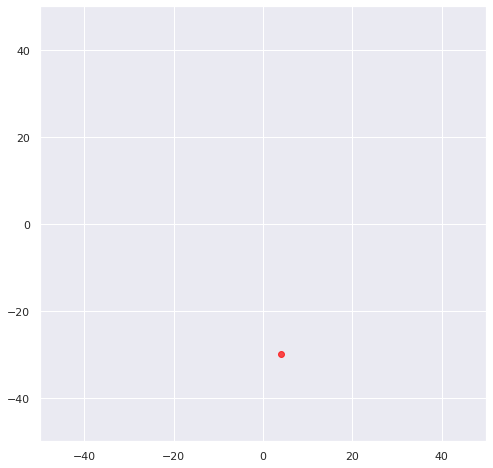

In [127]:
def make_ball() -> None:
    config = brax.Config(dt=0.1, substeps=4)
    # ボールを追加
    ball = config.bodies.add(name="ball", mass=1)
    capsule = ball.colliders.add().capsule
    capsule.radius = 0.5
    # y座標に重力
    config.gravity.y = GRAVITY
    return config


def make_qp(p, v) -> brax.QP:
    return brax.QP(
        pos=jnp.array([[p[0], p[1], 0.0]]),  # position
        vel=jnp.array([[v[0], v[1], 0.0]]),  # velocity
        rot=jnp.zeros((1,4)),  # rotation
        ang=jnp.zeros((1, 3)),  # angular velocity
    )


def simulate_one_ball_brax(n_steps: int = 100) -> t.List[Array]:
    sys = brax.System(make_ball())
    qp = make_qp([0.0, 48.0], [1.0, 0.0])
    results = []
    for _ in range(n_steps):
        qp, _ = sys.step(qp, [])
        results.append(qp.pos[:2])
    return results


HTML(ball_animation(simulate_one_ball_brax(40)).to_jshtml())

ここで、4つのAPIを使いました。
- `brax.Config`でシステムを定義
- `brax.System(config)`でシステムを作成
- `brax.QP`で初期位置・速度・アングル等を作成
- `brax.System.step(qp, ...)`で1ステップシミュレーションした結果を取得

ボールが一つだとなんとなく物足りないですね。増やしてみましょう。そのためには、[`jax.vmap`](https://jax.readthedocs.io/en/latest/jax.html#vectorization-vmap)で`sys.step`をベクトル化します。
デフォルトで、vmapは引数のテンソルに対する演算を`axis=0`でバッチ化します。
このあたりは`in_axes=(1, 0, ...)`とかやれば調節できますが、今回はデフォルトでOKです。

`[make_qp(*pv) for pv in zip(p, v)]`で、`List[brax.QP]`を作っていますが、これを[`jax.tree_map`](https://jax.readthedocs.io/en/latest/_autosummary/jax.tree_util.tree_map.html#jax.tree_util.tree_map)でもう一回QPに戻しています。
```
List[QP(p=(0, 0), v(0, 0)), QP(..), ...] 
```
が
```
QP(
    p=[(0, 0), (0.1, 0.2),. ...], 
    v=[(0, 0), (1, 2), ...],
)
```
に変換される感じです。
このジャーゴンは便利なので覚えてもいいと思います。
ちなみに、treemapのノードが葉かどうかはオブジェクトが[PyTreeか否か](https://jax.readthedocs.io/en/latest/pytrees.html)によります。
これは「以上のデータ構造をJaxは暗に木構造だとみなします。不足なら自分で登録してください」という話なので、最初は面食らうと思います。
これを陽なAPIでやろうにするとRustやScalaにあるtraitが必要なので、悪い設計ではないと思いますが。
というわけで、コードはこんな感じになります。

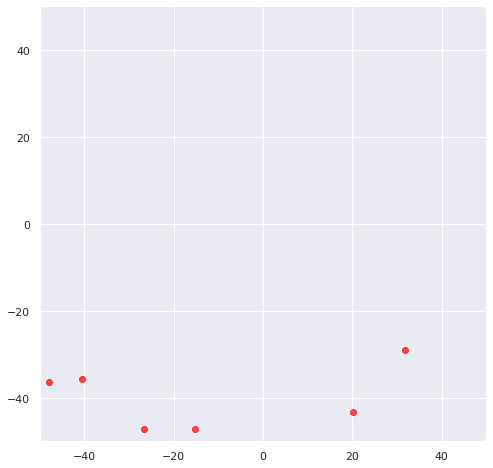

In [139]:
def simulate_balls_brax(n_balls: int, n_steps: int = 100) -> t.List[Array]:
    sys = brax.System(make_ball())
    p = np.random.uniform(size=(n_balls, 2), low=-50, high=50.0)
    v = np.random.randn(n_balls, 2)
    qps = [make_qp(*pv) for pv in zip(p, v)]
    qps = jax.tree_map(lambda *args: jnp.stack(args), *qps)
    # ここで
    step_vmap = jax.jit(jax.vmap(lambda qp: sys.step(qp, [])))
    results = []
    for _ in range(n_steps):
        qps, _ = step_vmap(qps)
        results.append(qps.pos[:, 0, :2])
    return results

HTML(ball_animation(simulate_balls_brax(20, 40)).to_jshtml())

jitを使わないとbraxがなぜかnumpyの関数を呼ぼうとしてエラーになったので、jitも併用しています。